In [128]:
pip install tensorflow matplotlib opencv-python

In [3]:
pip install numpy

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


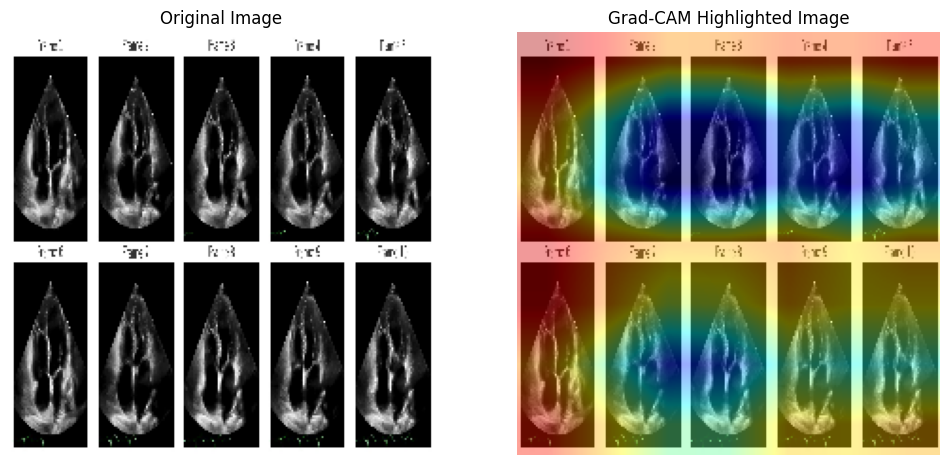

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the image
img_path = '/content/frame_0.jpg'
original_img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(original_img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Make predictions
preds = model.predict(x)
predicted_class = np.argmax(preds[0])

# Grad-CAM Implementation
last_conv_layer = model.get_layer('conv5_block3_out')  # Last convolutional layer

# Create a model that maps the input image to activations of the last conv layer and predictions
grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

# Compute the gradient of the predicted class with respect to the output feature map
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, predicted_class]

# Gradient of the loss with respect to the output feature map
grads = tape.gradient(loss, conv_outputs)[0]

# Mean intensity of the gradient for each feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight the output feature map by the computed gradients
conv_outputs = conv_outputs[0]
heatmap = np.mean(conv_outputs * pooled_grads[..., np.newaxis], axis=-1)

# Normalize the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
heatmap_colored = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.array(original_img), 0.6, heatmap_colored, 0.4, 0)

# Display Original and Grad-CAM Highlighted Image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# Grad-CAM Superimposed Image
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM Highlighted Image')
plt.axis('off')

plt.show()

In [9]:

!pip install shap
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0f01a8344493c0100eadd089cbd187c6141edf7ad8bbfbc987a822671d56ab6b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_738']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


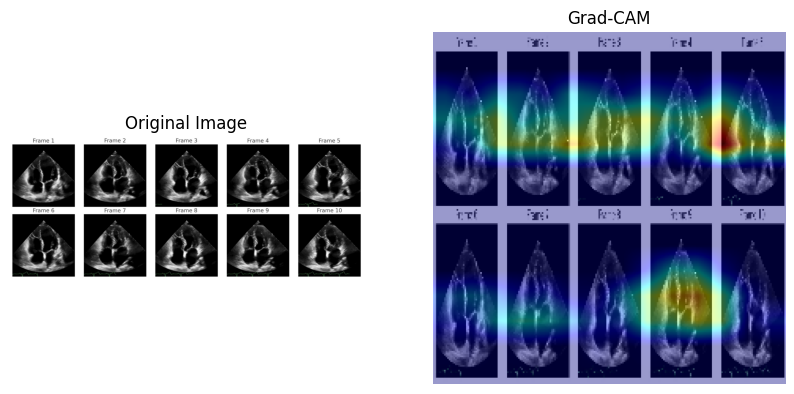

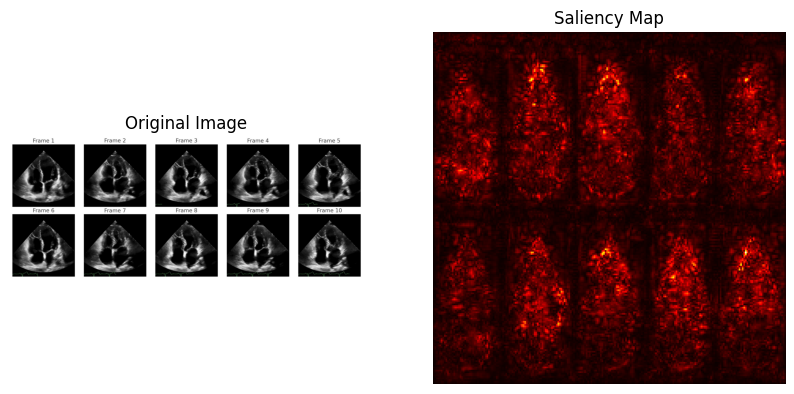

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import cv2

# Load the image
img_path = '/content/frame_0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Grad-CAM Implementation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads.numpy())  # Convert only pooled_grads if needed
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalization
    return heatmap

# Generate Grad-CAM heatmap
last_conv_layer_name = 'block5_conv3'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose heatmap on original image
def superimpose_heatmap(heatmap, original_img_path, alpha=0.4):
    img = cv2.imread(original_img_path)
    img = cv2.resize(img, (224, 224))
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return superimposed_img

# Display Original Image and Grad-CAM
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
original_image = cv2.imread(img_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM Visualization
plt.subplot(1, 2, 2)
superimposed_img = superimpose_heatmap(heatmap, img_path)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')

plt.show()

# Additional XAI Techniques: Saliency Map
inputs = tf.Variable(img_array, dtype=float)
with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = predictions[:, np.argmax(predictions)]

# Compute gradients
grads = tape.gradient(loss, inputs)[0]

# Take the absolute value of gradients and reduce along the color channels
saliency = np.max(np.abs(grads), axis=-1)  # Shape will be (224, 224)

# Normalize the saliency map for better visualization
saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)

# Plotting
plt.figure(figsize=(10, 5))

# Original Image Display
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Saliency Map Display
plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')  # Now it's 2D
plt.title("Saliency Map")
plt.axis('off')

plt.show()

In [2]:
pip install lime shap tensorflow matplotlib opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1fccbd22716bbe1ba724872bc70c568753ec381230c9d0aff1eb69a46608d56c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

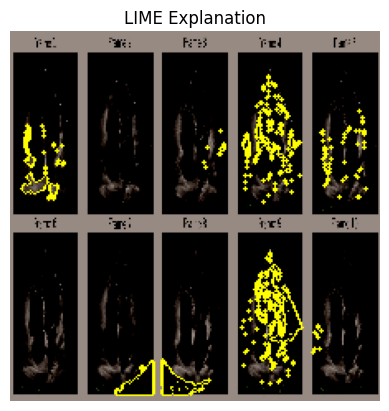

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load Image
img_path = '/content/frame_0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Load Model
model = VGG16(weights='imagenet')

# LIME Explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_array[0].astype('double'),
                                         model.predict,
                                         top_labels=1,
                                         hide_color=0,
                                         num_samples=500)  # Reduced samples for faster execution

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
lime_result = mark_boundaries(temp / 255.0, mask)

# Display LIME Result
plt.imshow(lime_result)
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

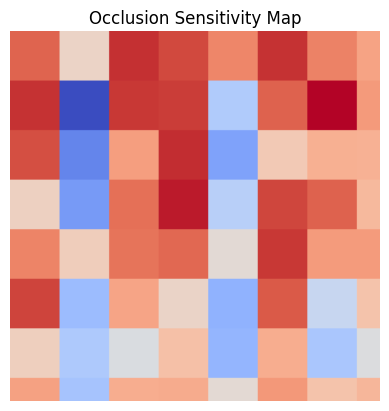

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

# Load Image
img_path = '/content/frame_0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Load Model
model = VGG16(weights='imagenet')

# Occlusion Sensitivity Function
def occlusion_sensitivity(img_array, model, patch_size=30):
    heatmap = np.zeros((224, 224))
    baseline_pred = model.predict(img_array)[0][np.argmax(model.predict(img_array))]

    for i in range(0, 224, patch_size):
        for j in range(0, 224, patch_size):
            img_occluded = img_array.copy()
            img_occluded[:, i:i+patch_size, j:j+patch_size, :] = 0
            occluded_pred = model.predict(img_occluded)[0][np.argmax(model.predict(img_occluded))]
            heatmap[i:i+patch_size, j:j+patch_size] = baseline_pred - occluded_pred

    return heatmap

# Run Occlusion Sensitivity
occlusion_map = occlusion_sensitivity(img_array, model)

# Display Occlusion Map
plt.imshow(occlusion_map, cmap='coolwarm')
plt.title("Occlusion Sensitivity Map")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# 1️⃣ Extract Frames from GIF
gif_path = '/content/WhatsApp GIF 2025-02-04 at 13.16.22.gif'
gif = Image.open(gif_path)

frames = []
try:
    while True:
        frame = gif.convert('RGB')
        frame = frame.resize((224, 224))  # Resize to VGG16 input size
        frames.append(np.array(frame))
        gif.seek(gif.tell() + 1)  # Move to the next frame
except EOFError:
    pass

# 2️⃣ Load Pre-trained Model
model = VGG16(weights='imagenet')

# Helper Function to Display Images
def display_image(img, title=''):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# 3️⃣ Processing Each Frame
for idx, selected_frame in enumerate(frames):
    print(f"Processing Frame {idx+1}/{len(frames)}")

    img_array = np.expand_dims(selected_frame, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    pred_label = decode_predictions(preds, top=1)[0][0][1]

    # LIME Explanation
    explainer_lime = lime_image.LimeImageExplainer()
    explanation = explainer_lime.explain_instance(selected_frame.astype('double'),
                                                  model.predict,
                                                  top_labels=1,
                                                  hide_color=0,
                                                  num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    lime_result = mark_boundaries(temp / 255.0, mask)

    # SHAP Explanation
    background = np.random.randn(10, 224, 224, 3)
    explainer_shap = shap.DeepExplainer(model, background)
    shap_values = explainer_shap.shap_values(img_array)

    # Occlusion Sensitivity Analysis
    def occlusion_sensitivity(img_array, model, patch_size=40):
        heatmap = np.zeros((224, 224))
        baseline_pred = model.predict(img_array)[0][np.argmax(model.predict(img_array))]

        for i in range(0, 224, patch_size):
            for j in range(0, 224, patch_size):
                img_occluded = img_array.copy()
                img_occluded[:, i:i+patch_size, j:j+patch_size, :] = 0
                occluded_pred = model.predict(img_occluded)[0][np.argmax(model.predict(img_occluded))]
                heatmap[i:i+patch_size, j:j+patch_size] = baseline_pred - occluded_pred

        return heatmap

    occlusion_map = occlusion_sensitivity(img_array, model)

    # 4️⃣ Visualization of XAI Techniques for Each Frame
    plt.figure(figsize=(15, 10))

    # Original Frame
    plt.subplot(2, 2, 1)
    display_image(selected_frame, f"Frame {idx+1}\n(Predicted: {pred_label})")

    # LIME Explanation
    plt.subplot(2, 2, 2)
    display_image(lime_result, "LIME Explanation")

    # SHAP Explanation
    plt.subplot(2, 2, 3)
    shap_image = np.abs(shap_values[0][0]).mean(axis=-1)
    plt.imshow(shap_image, cmap='hot')
    plt.title("SHAP Explanation")
    plt.axis('off')

    # Occlusion Sensitivity Map
    plt.subplot(2, 2, 4)
    plt.imshow(occlusion_map, cmap='coolwarm')
    plt.title("Occlusion Sensitivity Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing Frame 1/42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━